In [1]:
import numpy as np
import qutip as qt

/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


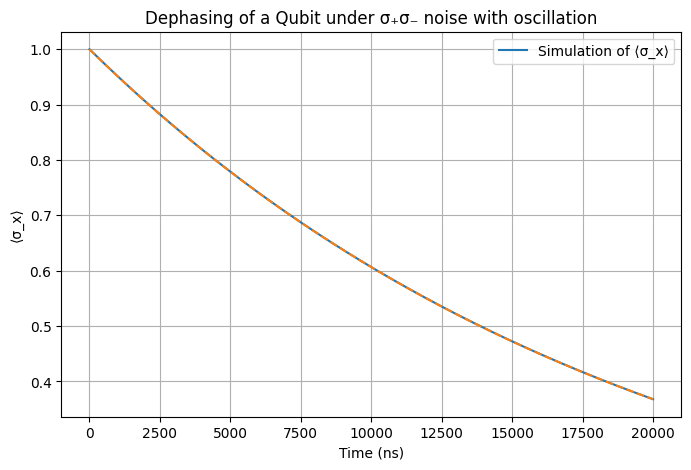

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Set parameters
sigma_p = sigmap()
sigma_m = sigmam()
noise = sigma_p * sigma_m  # Using σ₊σ₋ as the noise operator
gamma_relax = 1/20000
t_list = np.linspace(0, 20000, 50000)  # Time points for simulation (up to 2000 ns)
initial_state = (basis(2, 1)).unit()  # |+> state
sigma_x = sigmax()

# Hamiltonian
H0 = 4 * 2 * np.pi *  sigma_m * sigma_p 
H = [H0]

# Lindblad collapse operator
L =  np.sqrt(gamma_relax) * sigma_p
c_ops = [L,]

# Time evolution using mesolve
result = mesolve(
    H,
    initial_state,
    t_list,
    c_ops,
    e_ops=[initial_state* initial_state.dag()],
    options=Options(rtol=1e-14, atol=1e-14)
)

# Expectation value of σ_x
avg_sigma_x = result.expect[0]

# Exponential decay with oscillation fit
from scipy.optimize import curve_fit

def exp_decay_with_oscillation(t, tau):
    return np.exp(-t / tau) 

initial_guess = [2/gamma_relax]
params, covariance = curve_fit(exp_decay_with_oscillation, t_list, avg_sigma_x, p0=initial_guess)
tau = params

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(t_list, avg_sigma_x, label="Simulation of ⟨σ_x⟩")
plt.plot(
    t_list,
    exp_decay_with_oscillation(t_list, *params),
    linestyle="--"
)
plt.xlabel("Time (ns)")
plt.ylabel("⟨σ_x⟩")
plt.title("Dephasing of a Qubit under σ₊σ₋ noise with oscillation")
plt.legend()
plt.grid(True)
plt.show()


# Calculate and print rate




In [3]:
tau

array([20000.])

In [4]:
from system import *
def sort_floquet_modes(floquet_basis,t):
    # Compute Floquet modes and energies
    f_modes = floquet_basis.mode(t)
    f_energies = floquet_basis.e_quasi
    f_modes = np.array(f_modes)
    # Convert list of Qobj to numpy array
    f_modes_array = []
    for mode in f_modes:
        f_modes_array.append(mode.full().flatten())
    f_modes = np.array(f_modes_array)
    f_modes = f_modes.T
    evals, U = sort_eigenpairs(f_energies,f_modes)
    return evals,U

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import qutip as qt
from scipy.optimize import curve_fit
def floquet_tau(A_0, plot=True):
    # Set parameters
    sigma_p = sigmap()
    sigma_m = sigmam()
    gamma_relax = 1/20000
    total_time = 2000
    t_list = np.linspace(0, total_time, 50000)  # Time points for simulation (up to 2000 ns)

    sigma_x = sigmax()

    # Periodic drive parameters
    wd = 4.02 * 2*np.pi   # driving frequency (rad/ns)
    
    # Hamiltonian: time-independent part plus a periodic drive along σ_x
    H0 = 4 * 2 * np.pi * sigma_m * sigma_p 
    H = [H0, [sigma_x, lambda t, args: A_0 * np.cos(wd * t)]]

    # Calculate the period of the drive
    T = 2 * np.pi / wd
    floquet_basis = qt.FloquetBasis(H, T)
    _, U = sort_floquet_modes(floquet_basis,0)
    initial_state= qt.Qobj(U[:,1])

    result = mesolve(
        H,
        initial_state,
        t_list,
        c_ops,
        options=Options(rtol=1e-14, atol=1e-14,store_states=True)
    )
    avg_values = []
    for i in range(len(t_list)):
        _, U = sort_floquet_modes(floquet_basis, t_list[i])
        state_f = qt.Qobj(U[:,1])
        projector = qt.Qobj(state_f * state_f.dag())
        state_sim = result.states[i]
        avg_values.append(qt.expect(projector, state_sim))
    avg_values = np.array(avg_values)

    def exp_decay_with_oscillation(t, tau):
        return np.exp(-t / tau) 

    initial_guess = [2/gamma_relax]
    params, covariance = curve_fit(exp_decay_with_oscillation, t_list, avg_values, p0=initial_guess)
    tau_val = params[0]

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(t_list, avg_values, label="Simulation of ⟨σ_x⟩")
        plt.plot(
            t_list,
            exp_decay_with_oscillation(t_list, tau_val),
            linestyle="--"
        )
        plt.xlabel("Time (ns)")
        plt.ylabel("⟨σ_x⟩")
        plt.title("Dephasing of a Qubit under σ₊σ₋ noise with oscillation")
        plt.legend()
        plt.grid(True)
        plt.show()
        print(tau_val)
    
    return tau_val


In [6]:
def RWA_tau(A_0, plot=False):
    # Set parameters
    sigma_p = sigmap()
    sigma_m = sigmam()
    gamma_relax = 1/20000
    total_time = 2000  # ns: simulation time up to 2000 ns
    t_list = np.linspace(0, total_time, 50000)  # Time points for simulation
    sigma_x = sigmax()

    # Periodic drive parameters
    wd = 4.02 * 2*np.pi   # driving frequency (rad/ns), adjust as needed

    # Hamiltonian: time-independent part plus a periodic drive along σ_x
    H0 = (4 * 2 * np.pi - wd) * sigma_m * sigma_p + (A_0/2) * sigma_x
    HR = H0
    H = [HR]
    # Choose initial state from the eigenstates of HR
    eigen_info = HR.eigenstates()
    ground_state = eigen_info[1][1]
    excited_state = eigen_info[1][0]
    initial_state = excited_state

    # Lindblad collapse operator
    L = np.sqrt(gamma_relax) * sigma_p
    c_ops = [L]

    # Define the exponential decay function used for fitting
    def exp_decay_with_oscillation(t, tau):
        return np.exp(-t / tau)

    # Time evolution using mesolve
    result = mesolve(
        H,
        initial_state,
        t_list,
        c_ops,
        e_ops=[initial_state* initial_state.dag()],
        options=Options(rtol=1e-14, atol=1e-14)
    )
    avg_values = result.expect[0]
    initial_guess = [2/gamma_relax]
    params, covariance = curve_fit(exp_decay_with_oscillation, t_list, avg_values, p0=initial_guess)
    tau = params

    if plot:
        plt.figure(figsize=(8, 5))
        plt.plot(t_list, avg_values, label="Simulation of ⟨σ_x⟩")
        plt.plot(
            t_list,
            exp_decay_with_oscillation(t_list, tau),
            linestyle="--"
        )
        plt.xlabel("Time (ns)")
        plt.ylabel("⟨σ_x⟩")
        plt.title("Dephasing of a Qubit under σ₊σ₋ noise with oscillation")
        plt.legend()
        plt.grid(True)
        plt.show()
        print(tau)
    
    return tau

In [7]:
A_0 = 5e-3 * 2*np.pi
if_plot = False
f_tau = floquet_tau(A_0,if_plot)

In [8]:
R_tau = RWA_tau(A_0,if_plot)

/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/

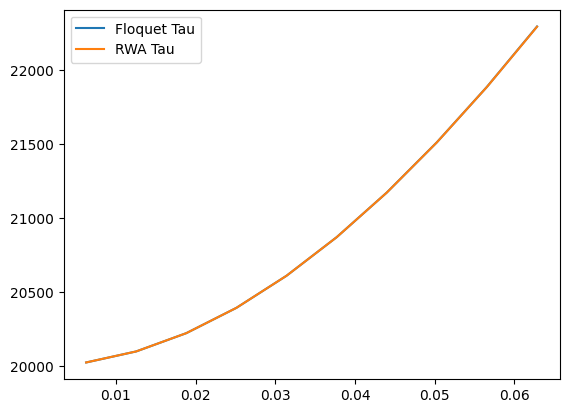

In [ ]:
from joblib import Parallel, delayed

A_0s = np.linspace(1e-3*2*np.pi, 10e-3*2*np.pi, 10)

def compute_taus(A_0):
    return floquet_tau(A_0, False), RWA_tau(A_0, False)

results = Parallel(n_jobs=-1)(delayed(compute_taus)(A_0) for A_0 in A_0s)
f_taus, R_taus = zip(*results)
f_taus, R_taus = list(f_taus), list(R_taus)


array([20025.03128911, 20100.50251256, 20227.56005057, 20408.16326531,
       20645.16129032, 20942.40837696, 21304.92676431, 21739.13043478,
       22253.12934631, 22857.14285714])

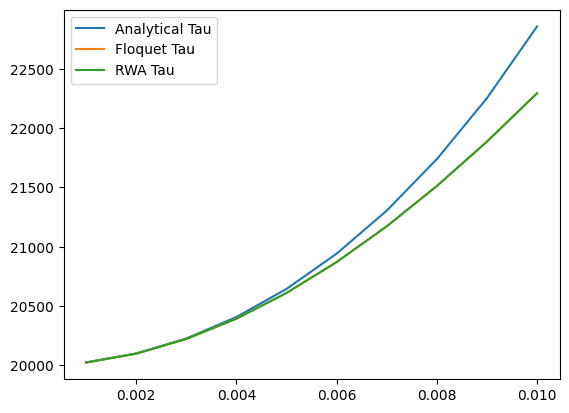

In [16]:
plt.plot(A_0s/2/np.pi,1/((1-2*(A_0s/2/(0.02*2*np.pi))**2)*gamma_relax),label="Analytical Tau")
plt.plot(A_0s/2/np.pi, f_taus, label="Floquet Tau")
plt.plot(A_0s/2/np.pi, R_taus, label="RWA Tau")
plt.legend()
plt.show()